#### Imports

In [383]:
using Plots
using Random
using LinearAlgebra

# Motion Planning Using Convex Optimization

## Model

In [384]:
struct Point
    x::Float64
    y::Float64
end

In [385]:
struct Pose
    position::Point
    orientation::Float64
end

## General Functions

In [386]:
function angleCalculator(dif_x, dif_y)
    ang_aux = 180*atan(dif_y,dif_x)/pi
    println("Raw angle = ", ang_aux)
    if (dif_x >=0 && dif_y >= 0) #top right
        ang_aux = 180 - ang_aux
    elseif (dif_x >=0 && dif_y < 0) #bot right
        ang_aux = abs(ang_aux) + 180
    elseif (dif_x < 0 && dif_y >= 0) #top left
        ang_aux = 180 - ang_aux
    elseif (dif_x < 0 && dif_y < 0) #bot left
        ang_aux = abs(ang_aux) + 180
    end
    println("Corrected angle = ", ang_aux, "\n\n")

    return ang_aux
end

angleCalculator (generic function with 1 method)

## Random Map Generation

### Random Convex Polygon Generation

In [387]:
function GenerateRandomConvexPolygon(numberOfVertices::Int64)
    rangeXmin = 0
    stepXmax = 1/floor(numberOfVertices/2)
    rangeXmax = stepXmax
    stepRange = 0.001
    odd = false

    randomXs = []
    randomYs = []
    points = []

    randDist = rand(0:0.001:0.3)
    xShift = maxPrevX + randDist
    
    if numberOfVertices%2 != 0
        odd = true
    end

    for i in 1:numberOfVertices
        println("rangeXmin: ", rangeXmin, ", rangeXmax: ", rangeXmax)
        if odd
            if i == 1
                println("odd 1")
                push!(randomXs,0)
                push!(randomYs,0.5)
            else
                println("odd else")
                if (i-1) < numberOfVertices/2
                    println("odd else if")
                    push!(randomXs,rand(rangeXmin:stepRange:rangeXmax))
                    push!(randomYs,rand(0:stepRange:0.5))
                    rangeXmin = rangeXmax + stepRange
                    rangeXmax += stepXmax
                else
                    println("odd else else")
                    rangeXmin -= stepXmax
                    rangeXmax -= stepXmax
                    push!(randomXs,rand(rangeXmin:stepRange:rangeXmax))
                    push!(randomYs,rand(0.501:stepRange:1))
                end
            end
        else
            if i ≤ numberOfVertices/2
                println("pair if")
                push!(randomXs,rand(rangeXmin:stepRange:rangeXmax))
                push!(randomYs,rand(0:stepRange:0.5))
                rangeXmin = rangeXmax + stepRange
                rangeXmax += stepXmax
            else
                println("pair else")
                rangeXmin -= stepXmax
                rangeXmax -= stepXmax
                push!(randomXs,rand(rangeXmin:stepRange:rangeXmax))
                push!(randomYs,rand(0.501:stepRange:1))
            end
        end
        println("x: ", randomXs[i], ", y: ", randomYs[i])
    end
          
    for i in 1:numberOfVertices
        push!(points,Point(randomXs[i]+xShift,randomYs[i]))
    end
    
    return points;
end

GenerateRandomConvexPolygon (generic function with 1 method)

In [388]:
n_obstacle = rand(1:10)
#n_obstacle = 1
obstacle = []
n_vertice = []
maxPrevX = 0
for i in 1:n_obstacle
    push!(n_vertice, rand(2:10))
    #push!(n_vertice, 5)
    push!(obstacle, GenerateRandomConvexPolygon(n_vertice[i]))
    for j in 1:n_vertice[i]
        maxPrevX = max(obstacle[i][j].x, maxPrevX)
    end
end

 #obstacle points
xs = []
ys = []
for i in 1:n_obstacle
    x_ob = []
    y_ob = []
    for j in 1:n_vertice[i]
        append!(x_ob, obstacle[i][j].x)
        append!(y_ob, obstacle[i][j].y)
    end
    append!(x_ob, obstacle[i][1].x)
    append!(y_ob, obstacle[i][1].y)
    push!(xs,x_ob)
    push!(ys,y_ob)
end



rangeXmin: 0, rangeXmax: 0.3333333333333333
pair if
x: 0.242, y: 0.224
rangeXmin: 0.3343333333333333, rangeXmax: 0.6666666666666666
pair if
x: 0.43633333333333335, y: 0.141
rangeXmin: 0.6676666666666666, rangeXmax: 1.0
pair if
x: 0.9196666666666666, y: 0.234
rangeXmin: 1.001, rangeXmax: 1.3333333333333333
pair else
x: 0.7336666666666667, y: 0.772
rangeXmin: 0.6676666666666666, rangeXmax: 1.0
pair else
x: 0.4893333333333333, y: 0.799
rangeXmin: 0.3343333333333333, rangeXmax: 0.6666666666666667
pair else
x: 0.057, y: 0.936
rangeXmin: 0, rangeXmax: 1.0
pair if
x: 0.214, y: 0.121
rangeXmin: 1.001, rangeXmax: 2.0
pair else
x: 0.7189999999999999, y: 0.925
rangeXmin: 0, rangeXmax: 0.25
odd 1
x: 0, y: 0.5
rangeXmin: 0, rangeXmax: 0.25
odd else
odd else if
x: 0.101, y: 0.24
rangeXmin: 0.251, rangeXmax: 0.5
odd else
odd else if
x: 0.455, y: 0.321
rangeXmin: 0.501, rangeXmax: 0.75
odd else
odd else if
x: 0.703, y: 0.22
rangeXmin: 0.751, rangeXmax: 1.0
odd else
odd else if
x: 0.976, y: 0.101
range

### Generating Random Bounds

In [389]:
xmap = zeros(5,1)
ymap = zeros(5,1)

α = zeros(1,2)
β = zeros(1,2)

for i in 1:2
    α[i] = rand(0:0.001:0.1*n_obstacle)
    β[i] = rand(0:0.001:0.2)
end

xmin_map = 10000
xmax_map = -10000
ymin_map = 10000
ymax_map = -10000

for i in 1:n_obstacle
    for j in 1:n_vertice[i]
        xmin_map = min(obstacle[i][j].x,xmin_map)
        println("xmin_map = ", xmin_map)
        xmax_map = max(obstacle[i][j].x,xmax_map)
        println("xmax_map = ", xmax_map)
        ymin_map = min(obstacle[i][j].y,ymin_map)
        println("ymin_map = ", ymin_map)
        ymax_map = max(obstacle[i][j].y,ymax_map)
        println("ymax_map = ", ymax_map)
    end
end


xmin = xmin_map - α[1]
xmax = xmax_map + α[2]
ymin = 0
ymax = ymax_map + β[2]

xmap[1:2] .= xmin
xmap[3:4] .= xmax
xmap[5] = xmin
ymap[1] = ymin
ymap[2:3] .= ymax
ymap[4] = ymin
ymap[5] = ymin

map_points = []
for i in 1:5
    push!(map_points, Point(xmap[i],ymap[i]))
end




xmin_map = 0.262
xmax_map = 0.262
ymin_map = 0.224
ymax_map = 0.224
xmin_map = 0.262
xmax_map = 0.45633333333333337
ymin_map = 0.141
ymax_map = 0.224
xmin_map = 0.262
xmax_map = 0.9396666666666667
ymin_map = 0.141
ymax_map = 0.234
xmin_map = 0.262
xmax_map = 0.9396666666666667
ymin_map = 0.141
ymax_map = 0.772
xmin_map = 0.262
xmax_map = 0.9396666666666667
ymin_map = 0.141
ymax_map = 0.799
xmin_map = 0.077
xmax_map = 0.9396666666666667
ymin_map = 0.141
ymax_map = 0.936
xmin_map = 0.077
xmax_map = 1.2286666666666666
ymin_map = 0.121
ymax_map = 0.936
xmin_map = 0.077
xmax_map = 1.7336666666666665
ymin_map = 0.121
ymax_map = 0.936
xmin_map = 0.077
xmax_map = 1.8816666666666664
ymin_map = 0.121
ymax_map = 0.936
xmin_map = 0.077
xmax_map = 1.9826666666666664
ymin_map = 0.121
ymax_map = 0.936
xmin_map = 0.077
xmax_map = 2.3366666666666664
ymin_map = 0.121
ymax_map = 0.936
xmin_map = 0.077
xmax_map = 2.5846666666666662
ymin_map = 0.121
ymax_map = 0.936
xmin_map = 0.077
xmax_map = 2.8576666666

### Convex Test for Polygons

In [390]:
function isConvex(points)
    convex = true
    i = 1
    m_min = 0
    m_max = 0
    prev = 0
    next = 0
    points_aux = []
    k = 1
    while (i <= length(points)) && convex
        prev = (length(points)+i-2)%(length(points))+1
        next = (i)%(length(points))+1

        # println("\nPonto atual: ", i, ", Ponto anterior: ", prev, " Ponto seguinte: ", next)

        x_prev = points[prev].x
        x_now = points[i].x
        x_next = points[next].x
        y_prev = points[prev].y
        y_now = points[i].y
        y_next = points[next].y

        # println("\nPonto atual: x = ", x_now, ", y = ", y_now, "\n")

        for j in 1:length(points)
            if (j != prev) && (j != next) && (j != i)
                # println("O ponto = ", j, " será analisado!")
                push!(points_aux, points[j])
                k += 1
            end
        end
        
        # println("\n")

        ang1 = 180*atan((y_prev - y_now)/(x_prev - x_now))/pi
        ang2 = 180*atan((y_next - y_now)/(x_next - x_now))/pi
        
        if (x_prev < x_now)
            ang1 = 180 + ang1
        end
        if (x_next < x_now)
            ang2 = 180 + ang2
        end

        if ang1<ang2 
            ang_min = ang1
            ang_max = ang2
        else
            ang_max = ang1
            ang_min = ang2
        end

        if (signbit(ang_min) != 1 && signbit(ang_max) != 1 && abs(ang_min-ang_max) > 180)
            ang_max = ang_max-360
            ang_aux = ang_min
            ang_min = ang_max
            ang_max = ang_aux
        elseif (signbit(ang_min) && abs(ang_min-ang_max) > 180)
            ang_min = 360 + ang_min
            ang_aux = ang_max
            ang_max = ang_min
            ang_min = ang_aux
        end

            

        # println("Ang_min = ", ang_min)
        # println("Ang_max = ", ang_max)

        for p in points_aux
            # println("\nPonto ", i, ", em relação ao Ponto x = ", p.x, ", y = ", p.y)
            ang = 180*atan((p.y - y_now)/(p.x - x_now))/pi
            if (p.x < x_now)
                ang = 180 + ang
            end
            if (ang < ang_min) || (ang > ang_max)
                if signbit(ang)
                    ang = 360+ang
                    if (ang < ang_min) || (ang > ang_max)
                        convex = false
                        # println("Não é convexo, pois ang = ", ang)
                        break
                    end
                else
                    ang = ang-360
                    if (ang < ang_min) || (ang > ang_max)
                        convex = false
                        # println("Não é convexo, pois ang = ", ang)
                        break
                    end
                end
            end
            # println("Sem problemas de convexidade, pois ang = ", ang)
        end

        points_aux = []

        i += 1
    end   
    return convex
end

isConvex (generic function with 1 method)

### Generating Raw Convex Polygons

In [391]:
function findPointInContact(m, x, y, dif_x, dif_y, ob_id, vertice_id, free_area)
    n = y - m*x
    if dif_x > 0
        reducing_x = true
    else
        reducing_x = false
    end

    if dif_y > 0
        reducing_y = true
    else
        reducing_y = false
    end
    println("reducing_x = ", reducing_x)
    println("reducing_y = ", reducing_y)
    points_in_contact = []
    points_aux = []
    same_obstacle_aux = []
    same_obstacle = []
    n_same_obstacle = 0
    n_aux = 0
    vert_prev = (n_vertice[ob_id]+vertice_id-2)%(n_vertice[ob_id])+1
    vert_next = (vertice_id)%(n_vertice[ob_id])+1
    
    #finding points in contact with other obstacles
    for i in 1:n_obstacle
        for j in 1:n_vertice[i]
            if (i == ob_id && j != vert_prev && j != vertice_id && j != vert_next) || i != ob_id
                prev = (n_vertice[i]+j-2)%(n_vertice[i])+1
                dif_x1 = obstacle[i][prev].x - obstacle[i][j].x
                dif_y1 = obstacle[i][prev].y - obstacle[i][j].y
                m1 = dif_y1 / dif_x1
                n1 = obstacle[i][j].y - m1*obstacle[i][j].x
                A = [-m 1; -m1 1]
                b = [n; n1]
                p1 = A\b
                x1min = min(obstacle[i][prev].x, obstacle[i][j].x) 
                x1max = max(obstacle[i][prev].x, obstacle[i][j].x)     
                #select just who is inside the bounds
                if p1[1] >= xmin && p1[1] <= xmax && p1[2] >= ymin && p1[2] <= ymax
                    #select just if touches on obstacles
                    if p1[1] > x1min && p1[1] < x1max
                        if i == ob_id
                            push!(same_obstacle_aux, true)
                        else
                            push!(same_obstacle_aux, false)
                        end
                        push!(points_aux, Point(p1[1],p1[2]))
                        n_aux += 1
                    end
                end
            end
        end
    end
    
    for i in 1:size(free_area,1)
        for j in 1:size(free_area[i],1)
            prev = (size(free_area[i],1)+j-2)%(size(free_area[i],1))+1
            dif_x1 = free_area[i][prev].x - free_area[i][j].x
            dif_y1 = free_area[i][prev].y - free_area[i][j].y
            m1 = dif_y1 / dif_x1
            n1 = free_area[i][j].y - m1*free_area[i][j].x
            A = [-m 1; -m1 1]
            b = [n; n1]
            println(cond(A))
            p1 = A\b            
            x1min = min(free_area[i][prev].x, free_area[i][j].x) 
            x1max = max(free_area[i][prev].x, free_area[i][j].x)     
            #select just who is inside the bounds
            if p1[1] >= xmin && p1[1] <= xmax && p1[2] >= ymin && p1[2] <= ymax
                #select just if touches on obstacles
                if p1[1] > x1min && p1[1] < x1max
                    push!(same_obstacle_aux, false)
                    push!(points_aux, Point(p1[1],p1[2]))
                    n_aux += 1
                end
            end
        end
    end 

    #select who is in the right direction
    for i in 1:n_aux
        if reducing_x && reducing_y
            if points_aux[i].x < x && points_aux[i].y < y
                push!(points_in_contact, points_aux[i])
                push!(same_obstacle, same_obstacle_aux[i])
            end
        elseif reducing_x && !reducing_y
            if points_aux[i].x < x && points_aux[i].y > y
                push!(points_in_contact, points_aux[i])
                push!(same_obstacle, same_obstacle_aux[i])
            end
        elseif !reducing_x && reducing_y
            if points_aux[i].x > x && points_aux[i].y < y
                push!(points_in_contact, points_aux[i])
                push!(same_obstacle, same_obstacle_aux[i])
            end
        else
            if points_aux[i].x > x && points_aux[i].y > y
                push!(points_in_contact, points_aux[i])
                push!(same_obstacle, same_obstacle_aux[i])
            end
        end
    end

    #finding who is the closest one
    min_line_width = 1000
    closest = 0
    for i in 1:size(points_in_contact,1)
        line_width = sqrt((points_in_contact[i].x - x)^2 + (points_in_contact[i].y - y)^2)
        if  line_width < min_line_width
            min_line_width = line_width
            closest = i
        end
        if same_obstacle[i]
            n_same_obstacle += 1
        end
    end

    println("n_same_obstacle: ", n_same_obstacle)

    #if there isn't any obstacle, line ends on map bounds
    if closest == 0
        if reducing_x
            x_t = xmin
        else
            x_t = xmax
        end
        
        y_f = m*x_t + n
    
        if y_f > ymax || y_f < ymin
            if reducing_y
                ya = ymin
            else
                ya = ymax
            end
            xa = (ya - n)/m
        else
            xa = x_t
            ya = y_f
        end
    else
        if same_obstacle[closest] && (n_same_obstacle % 2 != 0)
            xa = 12345
            ya = 12345
        else
            xa = points_in_contact[closest].x
            ya = points_in_contact[closest].y
        end
        
    end
     

    p = Point(xa,ya)
    
    return p
end

findPointInContact (generic function with 1 method)

In [392]:
function GenerateRawConvexPolygons()
    ob = obstacle
    free_area = []
    n = 0
    
    for i in 1:n_obstacle
        m = zeros(n_vertice[i],n_obstacle)
        dif_x = zeros(n_vertice[i],n_obstacle)
        dif_y = zeros(n_vertice[i],n_obstacle)
        for j in 1:n_vertice[i]
            println("----------------")
            println("obstacle ", i, ", point ", j, ", x = ",ob[i][j].x, " and y = ", ob[i][j].y)
            prev = (n_vertice[i]+j-2)%(n_vertice[i])+1
            println("prev = ", prev)
            println("--------------")
            println("dif_x[j,i] = ", dif_x[j,i])
            println("ob[i][prev].x = ", ob[i][prev].x)
            println("ob[i][j].x = ", ob[i][j].x)
            dif_x[j,i] = ob[i][prev].x - ob[i][j].x
            println("dif_x = ", dif_x[j,i])
            dif_y[j,i] = ob[i][prev].y - ob[i][j].y
            println("dif_y = ", dif_y[j,i])
            m[j,i] = dif_y[j,i] / dif_x[j,i]
            println("prev angle = ", m[j,i])
            println("----------------")
        end

        for j in 1:n_vertice[i]
            p_pol = []
            push!(p_pol,ob[i][j])
            p_aux = findPointInContact(m[j,i], ob[i][j].x, ob[i][j].y, dif_x[j,i], dif_y[j,i], i, j, free_area)
            push!(p_pol,p_aux)
            if p_aux.x != 12345 || p_aux.y != 12345
                push!(free_area,p_pol)
                n += 1
                println("n: ", n)
            end
        end
        
    end

    push!(free_area,n)
    return free_area
    
end

GenerateRawConvexPolygons (generic function with 1 method)

In [393]:
area = GenerateRawConvexPolygons()
n_freeLines = area[end]
println("n_freeLines: ", n_freeLines)
x_free = zeros(n_freeLines,2)
y_free = zeros(n_freeLines,2)

for i in 1:n_freeLines
    p = area[i]
    for j in 1:2
        x_free[i,j] = p[j].x
        y_free[i,j] = p[j].y
    end
    
end
area

----------------
obstacle 1, point 1, x = 0.262 and y = 0.224
prev = 6
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 0.077
ob[i][j].x = 0.262
dif_x = -0.185
dif_y = 0.7120000000000001
prev angle = -3.8486486486486493
----------------
----------------
obstacle 1, point 2, x = 0.45633333333333337 and y = 0.141
prev = 1
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 0.262
ob[i][j].x = 0.45633333333333337
dif_x = -0.19433333333333336
dif_y = 0.08300000000000002
prev angle = -0.4271012006861064
----------------
----------------
obstacle 1, point 3, x = 0.9396666666666667 and y = 0.234
prev = 2
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 0.45633333333333337
ob[i][j].x = 0.9396666666666667
dif_x = -0.4833333333333333
dif_y = -0.09300000000000003
prev angle = 0.19241379310344836
----------------
----------------
obstacle 1, point 4, x = 0.7536666666666667 and y = 0.772
prev = 3
--------------
dif_x[j,i] = 0.0
ob[i][prev].x = 0.9396666666666667
ob[i][j].x = 0.7536666666666667
dif_x = 0.1

36-element Vector{Any}:
   Any[Point(0.262, 0.224), Point(0.3202022471910112, 0.0)]
   Any[Point(0.45633333333333337, 0.141), Point(0.7864658634538152, 0.0)]
   Any[Point(0.9396666666666667, 0.234), Point(1.3491294461437886, 0.31278628653387386)]
   Any[Point(0.7536666666666667, 0.772), Point(0.6157224287484511, 1.171)]
   Any[Point(0.077, 0.936), Point(-0.442, 1.1004633770239014)]
   Any[Point(1.2286666666666666, 0.121), Point(1.152665422885572, 0.0)]
   Any[Point(1.7336666666666665, 0.925), Point(1.8881815920398006, 1.171)]
   Any[Point(1.8816666666666664, 0.5), Point(1.309486154285918, 0.24967102583342196)]
   Any[Point(1.9826666666666664, 0.24), Point(2.0758974358974354, 0.0)]
   Any[Point(2.8576666666666664, 0.101), Point(3.089372549019608, 0.0)]
   Any[Point(2.685666666666666, 0.507), Point(2.4043661740558284, 1.171)]
   Any[Point(2.5536666666666665, 0.758), Point(2.336471447543161, 1.171)]
   Any[Point(2.3426666666666662, 0.903), Point(1.952680459770114, 1.171)]
  ⋮
   Any[Point

## Plotting Map

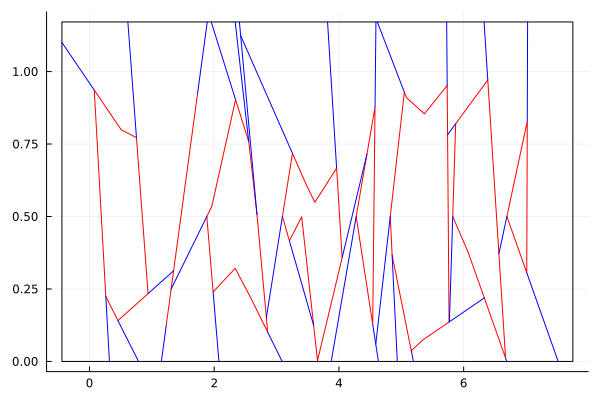

In [394]:
plot(xs[1][:],ys[1][:], linecolor = :red)
for i in 2:n_obstacle
    plot!(xs[i][:],ys[i][:], linecolor = :red)
end
plot!(xmap, ymap, linecolor = RGB(0,0,0), legend = false)
for i in 1:n_freeLines-1
    plot!(x_free[i,:],y_free[i,:], linecolor = :blue)
end
plot!(x_free[n_freeLines,:],y_free[n_freeLines,:], linecolor = :blue, legend = false)


In [395]:
obstacle

8-element Vector{Any}:
 Any[Point(0.262, 0.224), Point(0.45633333333333337, 0.141), Point(0.9396666666666667, 0.234), Point(0.7536666666666667, 0.772), Point(0.5093333333333333, 0.799), Point(0.077, 0.936)]
 Any[Point(1.2286666666666666, 0.121), Point(1.7336666666666665, 0.925)]
 Any[Point(1.8816666666666664, 0.5), Point(1.9826666666666664, 0.24), Point(2.3366666666666664, 0.321), Point(2.5846666666666662, 0.22), Point(2.8576666666666664, 0.101), Point(2.685666666666666, 0.507), Point(2.5536666666666665, 0.758), Point(2.3426666666666662, 0.903), Point(1.9616666666666662, 0.535)]
 Any[Point(3.0936666666666666, 0.5), Point(3.2056666666666667, 0.416), Point(3.4026666666666667, 0.499), Point(3.6566666666666663, 0.003), Point(4.051666666666667, 0.358), Point(3.9626666666666663, 0.667), Point(3.6136666666666666, 0.549), Point(3.4776666666666665, 0.609), Point(3.2546666666666666, 0.718)]
 Any[Point(4.276666666666666, 0.5), Point(4.541666666666666, 0.128), Point(4.578666666666666, 0.877)]
 Any

In [396]:
for ob in obstacle
     if isConvex(ob)
        println("é convexo")
     else
        println("não é")
     end
end

não é
é convexo
não é
não é
é convexo
não é
não é
é convexo
